# Interactive nuclear segmentation notebook
For internal Finn Lab use; Rehaul as of May, 2023

#### Will: 
1) Find images (formatted for ImageXpress files)
2) Load 9 at random
3) Filter using an unsharp filter and Richardson-Lucy deconvolution
4) Run filtered images through segmentation using CellPose
5) Display CellPose results

Add notes here as you like!

#### First, set basic parameters such as microscope used and channel assignments. Microscope needs to be set as an environment variable, so do this first.

In [1]:
from datetime import datetime

IMAGE_LOCATION = "/hpc-prj/finn/data/AG/"
ANALYSIS_PREFIX = "20230718"
MICROSCOPE = "LSM"
USER = "edwardsl"
DAPI_CHANNEL = 1
NUCLEAR_DIAMETER = 50

#### Import dependencies and set environment variables.

In [2]:
import os
os.environ["FILE_TYPE"] = MICROSCOPE
os.environ["USER"] = USER

import numpy
import random
from matplotlib import pyplot
from cellpose import core, utils, io, models, metrics
import re
import skimage

from generate_maximum_projection import *
from models.image_filename import *
from models.image_filename_glob import *
from models.paths import *
from models.labels import *
from models.swarm_job import SwarmJob, RunStrategy

from generate_all_maximum_projections import GenerateAllMaximumProjectionsJob
from generate_all_nuclear_segmentations import GenerateAllNuclearSegmentationsJob
from generate_all_nuclear_masks import GenerateAllNuclearMasksJob
from generate_all_distance_transforms import GenerateAllDistanceTransformsJob
from generate_all_cropped_cell_images import GenerateAllCroppedCellImagesJob
from generate_all_cell_result_lines import GenerateAllCellResultLinesJob
from generate_cell_results_file import GenerateCellResultsFileJob


# Begin interactive test analysis. Use the following four chunks to test the nuclear segmentation. If needed, change the diameter parameter to fine-tune the segmentation.

#### Find all the fields in an experiment folder

In [4]:
#Define source folder
source = source_path(IMAGE_LOCATION)

#Find images within source folder by matching pattern
all_images = source.rglob(str(ImageFilenameGlob(c=DAPI_CHANNEL, suffix="", extension="tif")))
all_image_names = (ImageFilename.parse(str(image_file_path.relative_to(source))) for image_file_path in all_images)

#Find positions
def distinct_positions(image_names):
    positions = set(ImageFilenameGlob.from_image_filename(image_filename, excluding_keys=["z"]) for image_filename in image_names)
    return positions

positions = distinct_positions(all_image_names)
positions_list = ([str(position) for position in positions])
NUM_POSITIONS = len(positions_list)
print("Found %i positions:"%NUM_POSITIONS)
print(*positions_list[:min(NUM_POSITIONS,10)], sep="\n")

Found 54 positions:
20230711/CS3/50_6_T3 Stack 1_2023_07_11__12_24_40/p3/ch1/z?*.tif
20230718/CS2/50_6_T3 Stack 1_2023_07_18__10_01_52/p3/ch1/z?*.tif
20230706/CS2/50_6_T3 Stack 1_2023_07_06__11_55_26/p5/ch1/z?*.tif
20230706/CS1/50_6_T3 Stack 1_2023_07_06__11_05_52/p3/ch1/z?*.tif
20230706/CS2/50_6_T3 Stack 1_2023_07_06__11_55_26/p8/ch1/z?*.tif
20230718/CS4/50_6_T3 Stack 1_2023_07_18__11_50_04/p3/ch1/z?*.tif
20230718/CS4/50_6_T3 Stack 1_2023_07_18__12_17_20/p2/ch1/z?*.tif
20230718/CS3/50_6_T3 Stack 1_2023_07_18__10_27_42/p2/ch1/z?*.tif
20230711/CS2/50_6_T3 Stack 1_2023_07_11__10_52_04/p2/ch1/z?*.tif
20230718/CS3/50_6_T3 Stack 1_2023_07_18__10_27_42/p1/ch1/z?*.tif


#### If more than nine images, take a random sample of the above table, load the images, and take a maximum projection

looking for source files with pattern 20230718/CS4/50_6_T3 Stack 1_2023_07_18__12_17_20/p4/ch1/z?*.tif
found /hpc-prj/finn/data/AG/20230718/CS4/50_6_T3 Stack 1_2023_07_18__12_17_20/p4/ch1/z3.tif
looking for source files with pattern 20230718/CS4/50_6_T3 Stack 1_2023_07_18__12_17_20/p4/ch1/z?*.tif
found /hpc-prj/finn/data/AG/20230718/CS4/50_6_T3 Stack 1_2023_07_18__12_17_20/p4/ch1/z3.tif
looking for source files with pattern 20230706/CS2/50_6_T3 Stack 1_2023_07_06__11_55_26/p2/ch1/z?*.tif
found /hpc-prj/finn/data/AG/20230706/CS2/50_6_T3 Stack 1_2023_07_06__11_55_26/p2/ch1/z03.tif
looking for source files with pattern 20230706/CS2/50_6_T3 Stack 1_2023_07_06__11_55_26/p2/ch1/z?*.tif
found /hpc-prj/finn/data/AG/20230706/CS2/50_6_T3 Stack 1_2023_07_06__11_55_26/p2/ch1/z03.tif
looking for source files with pattern 20230627/CS3/50_6_T3 Stack 1_2023_06_27__10_02_57/p2/ch1/z?*.tif
found /hpc-prj/finn/data/AG/20230627/CS3/50_6_T3 Stack 1_2023_06_27__10_02_57/p2/ch1/z3.tif
looking for source file

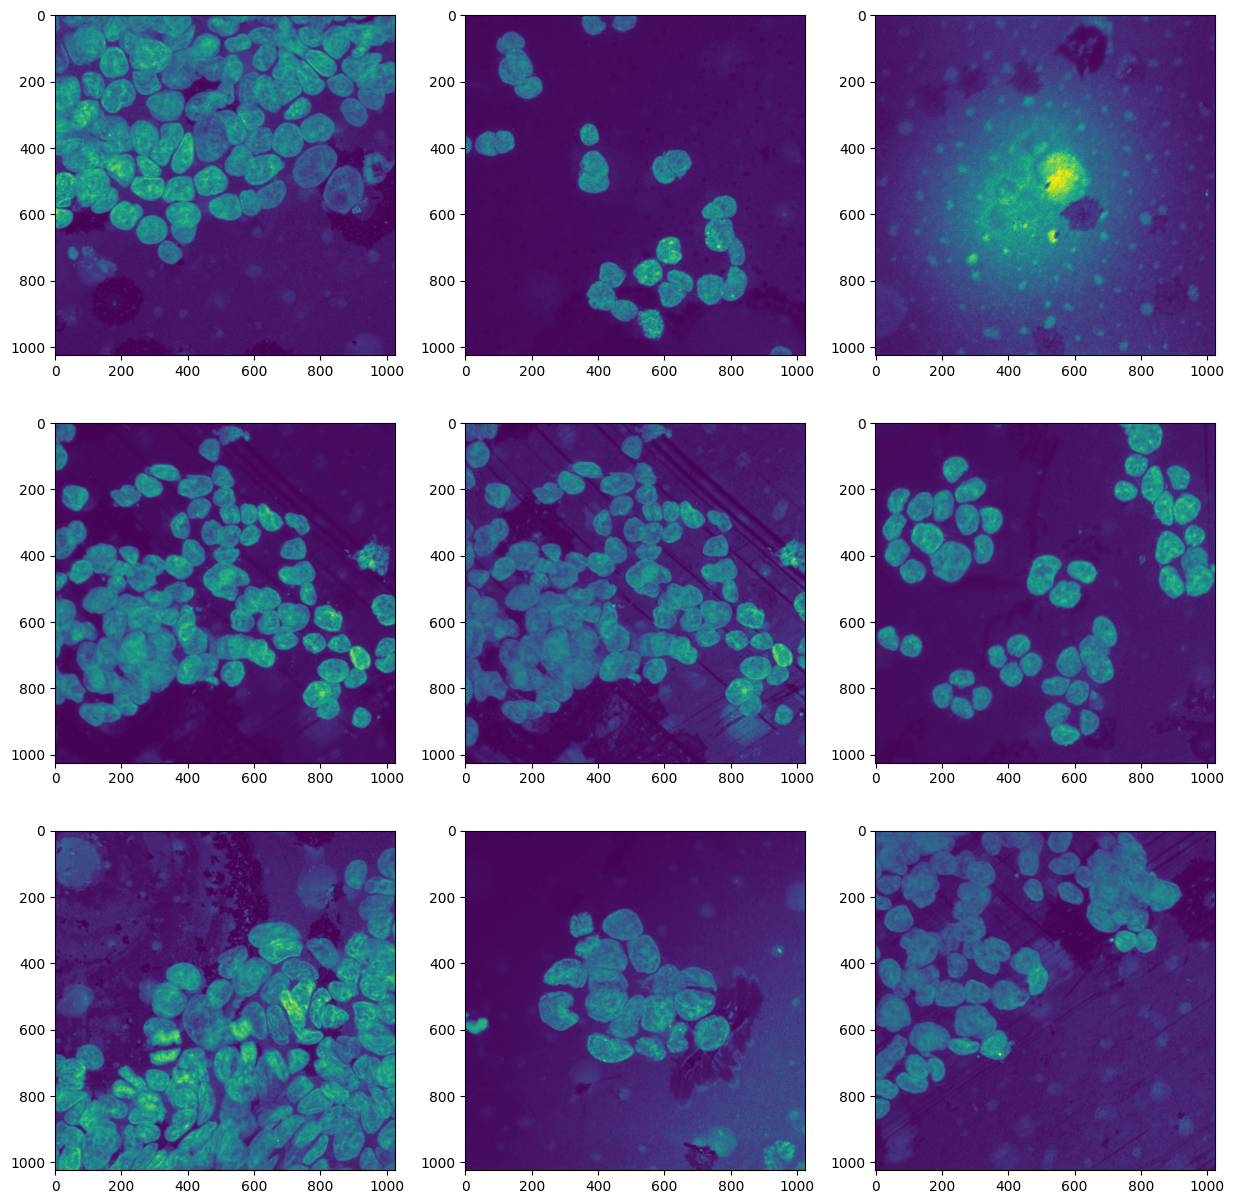

In [6]:
def make_mp(pos):
    stack = GenerateMaximumProjectionJob(source, pos, "NULL")
    return stack.maximum_projection

SAMPLE_SIZE = min(NUM_POSITIONS, 9)
ROWS = (((SAMPLE_SIZE-1)//3) + 1)
COLS = 3
sample = random.sample(positions_list, SAMPLE_SIZE)
imgs = [make_mp(position) for position in sample]

fig, axs = pyplot.subplots(ROWS,COLS)

for i in range(0,SAMPLE_SIZE):
    ax = axs[i//3, i%3]
    ax.imshow(imgs[i])
for i in range(SAMPLE_SIZE,COLS*ROWS):
    ax = axs[i//3, i%3]
    ax.imshow(numpy.ones_like(imgs[SAMPLE_SIZE-1]))
    
fig.set_size_inches(COLS*5,ROWS*5)
fig.canvas.draw()

In [7]:
model = models.Cellpose(model_type='nuclei')

masks, flows, styles, diams = model.eval([imgs[i] for i in range(0,SAMPLE_SIZE)], channels=[0,0], resample=True, do_3D=False, diameter=NUCLEAR_DIAMETER)

print(numpy.shape(masks))

(9, 1024, 1024)


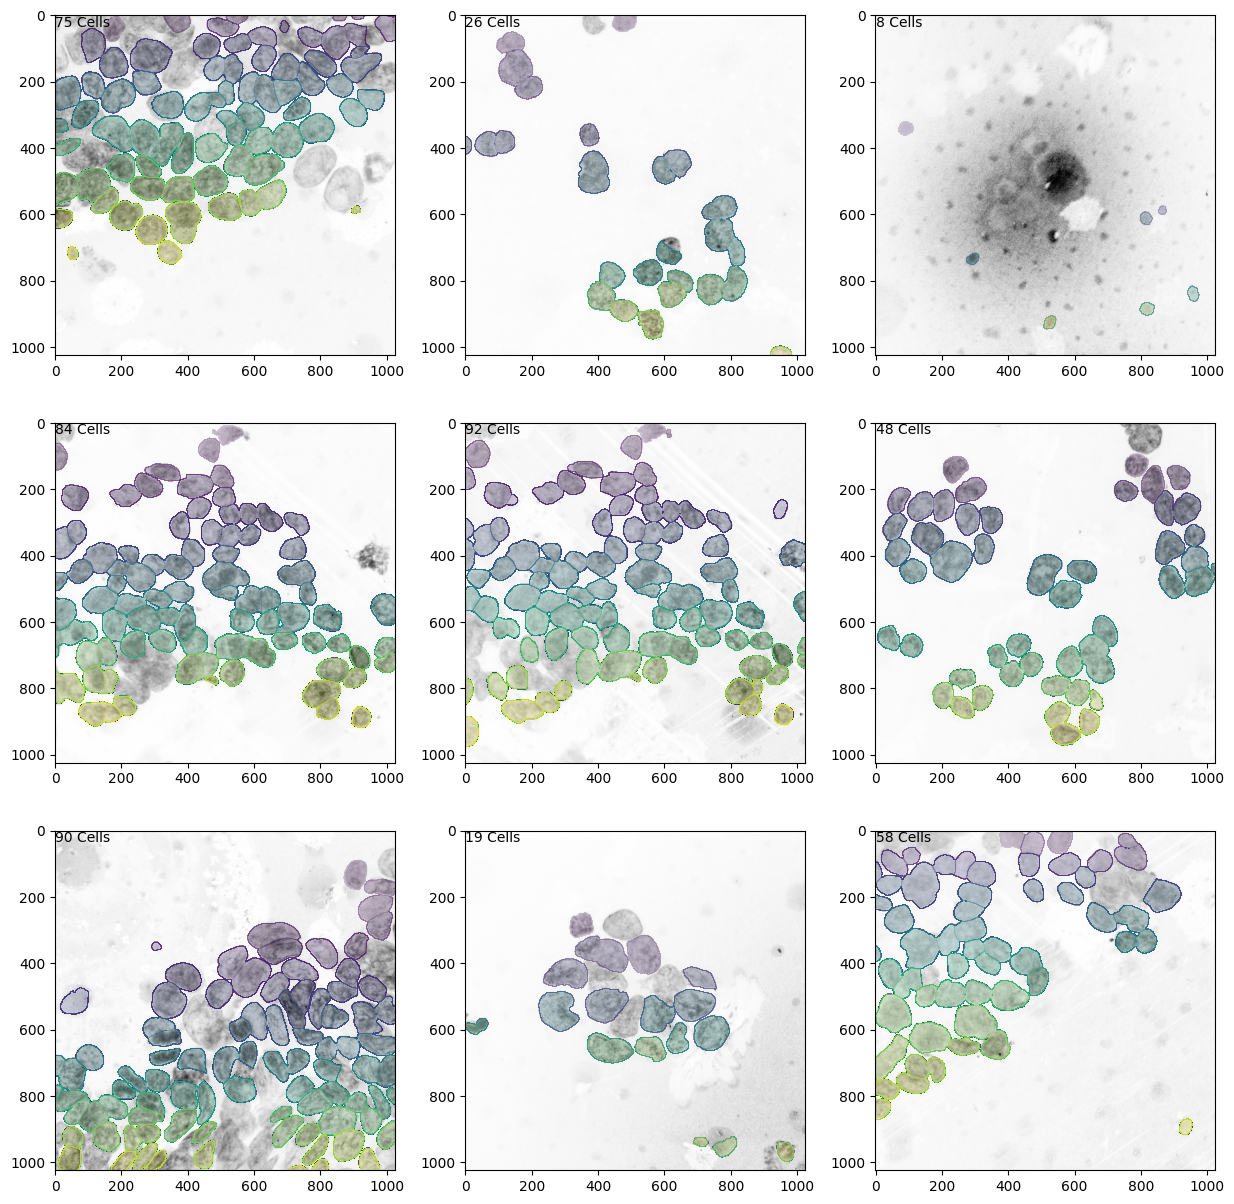

In [8]:
## Display the segmentation result and cell counts:
def distinct_labels(label_matrix):
  distinct_labels_set = set()
  for labels_row in label_matrix:
      for label in labels_row:
          distinct_labels_set.add(label)
  distinct_labels_set.remove(0)
  return [label for label in distinct_labels_set]


labels = [distinct_labels(masks[i]) for i in range(0,SAMPLE_SIZE)]

fig, axs = pyplot.subplots(ROWS,COLS)

for i in range(0,SAMPLE_SIZE):
    ax = axs[i//3, i%3]
    ax.imshow(imgs[i], cmap="Greys")
    if len(labels[i]) > 1:
        ax.contourf(masks[i], levels=labels[i], alpha=0.2)
        ax.text(0.0, 1.0, "%i Cells"%(max(labels[i])),
            fontsize='medium', verticalalignment='top')
    else:
        ax.text(0.0, 1.0, "No Cells",
            fontsize='medium', verticalalignment='top')
for i in range(SAMPLE_SIZE,COLS*ROWS):
    ax = axs[i//3, i%3]
    ax.imshow(numpy.ones_like(imgs[SAMPLE_SIZE-1]))
    
fig.set_size_inches(COLS*5,ROWS*5)
fig.canvas.draw()

#Like what you see? The chunks below will build a shell script to process your images with these parameters.

##First: take the system variables that you set above and use them to generate directories for results folders. Worth checking that these are sensible to you.

In [10]:
SwarmJob.run_strategy = RunStrategy.SWARM

scratch_directory = Path("/s/finn-lab/AG_0718")
results_directory = Path("/hpc-prj/finn/Results")
MIP_directory = scratch_directory / "MIPs/"
nuclear_segmentations_directory = scratch_directory / "segs/" 
nuclear_masks_directory = scratch_directory / "masks/"
distance_transforms_directory = scratch_directory / "dts/"
cell_crops_directory = scratch_directory / "crops/"
cell_result_lines_directory = scratch_directory / "cell_results/"

log_files_directory = results_directory/ "logs/"

##Finally: call scripts to find files, break them down into appropriate chunks for parallel processing, and write the command line calls into the shell script. 

Note that it's important to run each of these one-at-a-time, because the job submission system makes it seem like a job has completed before it really has. Run a chunk and wait to get an email that it's completed before moving on to the next one.

Steps that this includes: 
1) Generate All Maximum Projections Job: Calculates maximum projections, weighted-average z positions, and vertically-integrated intensities
2) Generate All Nuclear Segmentations Job: Uses CellPose to generate nuclear segmentations
3) Generate All Nuclear Masks Job: Turns cellpose results into nuclear masks
4) Generate All Distance Transforms Job: Uses nuclear masks to calculate normalized radial position for each pixel within the nucleus (0 = most central, 1 = most peripheral)
5) Generate All Cropped Cell Images Job: crops images in all channels to get one cell and one channel per image
6) Generate All Cell Result Lines Job: calculates integrated intensity in all channels, as well as cell size and shape parameters, for each cell
7) Generate Cell Results File Job: concatenates cell result lines into a single tab separated file for downstream analysis

### Each chunk will generate a shell script, run it, and email you approximately when it is completed. However, it is generally faster and more reliable to monitor the shell script using the "squeue" command on the command line. Do not run chunk two until the shell script in chunk one has finished running, since the files will not be all generated and will therefore get lost.

In [12]:
GenerateAllMaximumProjectionsJob(IMAGE_LOCATION, 
                                 MIP_directory, 
                                 log_files_directory).run()

Generating file dictionary (this can take a while)
running generate_all_maximum_projections_20230720154716 in parallel mode
['sbatch', '--wait', PosixPath('/s/finn-lab/AG_0718/MIPs/generate_all_maximum_projections_20230720154716.sh')]


Submitted batch job 1911031


In [13]:
GenerateAllNuclearSegmentationsJob(MIP_directory, 
                                   nuclear_segmentations_directory, 
                                   log_files_directory, 
                                   NUCLEAR_DIAMETER, DAPI_CHANNEL).run()

Generating file dictionary (this can take a while)
running generate_all_nuclear_segmentations_20230720154835 in parallel mode
['sbatch', '--wait', PosixPath('/s/finn-lab/AG_0718/segs/generate_all_nuclear_segmentations_20230720154835.sh')]


Submitted batch job 1911036


In [14]:
GenerateAllNuclearMasksJob(nuclear_segmentations_directory, 
                           nuclear_masks_directory, 
                           log_files_directory).run()

Generating file dictionary (this can take a while)
running generate_all_nuclear_masks_20230720155255 in parallel mode
['sbatch', '--wait', PosixPath('/s/finn-lab/AG_0718/masks/generate_all_nuclear_masks_20230720155255.sh')]


Submitted batch job 1911041


In [15]:
GenerateAllDistanceTransformsJob(nuclear_masks_directory, 
                                 distance_transforms_directory, 
                                 log_files_directory).run()

Generating file dictionary (this can take a while)
running generate_all_distance_transforms_20230720155336 in parallel mode
['sbatch', '--wait', PosixPath('/s/finn-lab/AG_0718/dts/generate_all_distance_transforms_20230720155336.sh')]


Submitted batch job 1911044


In [16]:
GenerateAllCroppedCellImagesJob(MIP_directory, 
                                nuclear_masks_directory, 
                                cell_crops_directory, 
                                log_files_directory, DAPI_CHANNEL).run()

Generating file dictionary (this can take a while)
running crop_230720155353 in parallel mode
['sbatch', '--wait', PosixPath('/s/finn-lab/AG_0718/crops/crop_230720155353.sh')]


Submitted batch job 1911045


In [17]:
GenerateAllCellResultLinesJob(MIP_directory, 
                                nuclear_masks_directory, 
                                cell_result_lines_directory, 
                                log_files_directory).run()

Generating file dictionary (this can take a while)
running generate_all_cell_result_lines_20230720155533 in parallel mode
['sbatch', '--wait', PosixPath('/s/finn-lab/AG_0718/cell_results/generate_all_cell_result_lines_20230720155533.sh')]


Submitted batch job 1911046


In [18]:
GenerateCellResultsFileJob(cell_result_lines_directory, results_directory, ANALYSIS_PREFIX).run()